In [ ]:
import os
import re
from tqdm import tqdm
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from keras.layers import Embedding
from  keras . utils  import  to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D,Conv2D, MaxPooling1D, Embedding, Flatten
from keras.models import Model
from keras.initializers import Constant
from keras.layers import Embedding
import tensorflow as tf


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd 
df_train=pd.read_csv('gdrive/My Drive/Thesis Data/full doc csv/full_doc_train.csv')
df_test=pd.read_csv('gdrive/My Drive/Thesis Data/full doc csv/full_doc_test.csv')
total_data = pd.concat([df_train,df_test])
# we have to works with word level,if we works with charchter level then it exits the RAM limit
# here remove 'politics','education','sports' labels of text which is frequently occur in dataset and set it to news_3less.csv file
total_data = total_data[total_data['label']!='politics'] # remove the label which is 'politics'
total_data = total_data[total_data['label']!='education'] # remove the label which is 'education'
total_data = total_data[total_data['label']!='sports'] # remove the label which is 'sports'
print(len(total_data))
# df.to_csv(news/'news_3less.csv',index=False) # convert the data to csv format

51690


In [ ]:
stopwords=pd.read_csv('gdrive/My Drive/Colab Notebooks/Stopwords.csv')


In [ ]:
!git clone -l -s https://github.com/banglakit/bengali-stemmer.git

Cloning into 'bengali-stemmer'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 94 (delta 5), reused 16 (delta 4), pack-reused 69
Unpacking objects: 100% (94/94), done.


In [ ]:
!pip install git+https://github.com/banglakit/bengali-stemmer.git    

  Cloning https://github.com/banglakit/bengali-stemmer.git to /tmp/pip-req-build-09itltc_
  Running command git clone -q https://github.com/banglakit/bengali-stemmer.git /tmp/pip-req-build-09itltc_
  Created wheel for bengali-stemmer: filename=bengali_stemmer-0.0.1-py2.py3-none-any.whl size=6393 sha256=4c51f5f6a929a072c4c578ed0f782057bc0824070be7c18fe1ddaed6d31aa19c
  Stored in directory: /tmp/pip-ephem-wheel-cache-zirqb6hs/wheels/a1/ad/a1/4ba354059b17c00600a14e13a504e7bdb49f20f2f4e2f3639c
Successfully built bengali-stemmer


In [ ]:
from bengali_stemmer.rafikamal2014 import RafiStemmer
stemmer = RafiStemmer()
stemmer.stem_word('বাংলায়')

'বাংলা'

In [ ]:
macronum=sorted(set(total_data['label']))
macro_to_id = dict((note, number) for number, note in enumerate(macronum))

def fun(i):
    return macro_to_id[i]

total_data['label']=total_data['label'].apply(fun)


In [ ]:
texts = list(total_data['text'])
labels = list(total_data['label'])

In [ ]:
def clean_punct(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#|।|’|‘]', r'', sentence)
    cleaned1 = re.sub(r'[.|,|(|)|\|/]', r'', cleaned)
    cleaned = re.sub(r'[০|১|২|৩|৪|৫|৬|৭|৮|৯]', r'', cleaned1)
    cleaned1 = re.sub(r'[-|=]', r' ', cleaned)
    return cleaned1

In [ ]:
set_stop = set(stopwords['words'])

In [ ]:

def pre_process(data):
    i=0
    str1=' '
    final_string = []
    final_words = []
    all_negative_words = []
    s=''

    for sentence in data:
        filtered_sentence = []

        for w in sentence.split():
            for cleaned_word in clean_punct(w).split():
                if len(cleaned_word)>2:
                    if((cleaned_word) not in set_stop):
                        s = stemmer.stem_word(cleaned_word)
                        if len(s)>2:
                            final_words.append(s)
                            filtered_sentence.append(s)
                    else:
                        continue
                else:
                    continue

        str1 = " ".join(filtered_sentence)
        final_string.append(str1)
    return final_string

In [ ]:
texts = pre_process(texts)

In [ ]:
texts[0]

'উচ্চ মাধ্যমিক পরীক্ষ মঙ্গলব বিবৃতি মন্ত্রী “আমি হরতাল অবরোধ সন্ত্রাসী কার্যক্রম পরিচালনাকারী জোট আহ্বান জানা পরীক্ষার্থী শান্তিপূর্ণভাব পরীক্ষা দয়া হটকারী ঘটনা ঘটাব “আমি ভাষা দেশ স্থান একজন পরীক্ষার্থীর ক্ষতি দায়দায়িত্ব আপনা বহন মানুষ আপনা ক্ষমা না” জানুয়ারি দেশ টানা অবরোধ চালি আসা বিএনপি জোট ফেব্রুয়ারি মার্চ বেশিরভাগ প্রতিদিন হরতাল বিএনপি জোট অবরোধ হরতাল চলতি এসএসসি সমমান অর্থাৎ দিন পরীক্ষা পেছা বাধ্য শিক্ষা মন্ত্রণাল পরীক্ষা দিন শুক্র শনিব ধরন রাজনৈতিক কর্মসূচির কারণ এইচএসসি পরীক্ষা পেছানো রেখ শিক্ষামন্ত্রী ফাইল বিবৃতি নাহিদ “সংকট এসএসসি পরীক্ষা শেষ এইচএসসি পরীক্ষা জাতির দুর্ভাগ্য রাজনৈতিক জোট বিবেকবর্জিত অব্যাহত হরতাল অবরোধ কারণ এসএসসির রুটিন পরীক্ষা সম্ভব “পরীক্ষার্থী অভিভাবক শিক্ষকসহ শ্রেণি পেশ মানুষ মতামত পরামর্শ সম্মান দেখি পরিস্থিতি রুটিনমাফিক পরীক্ষা সিদ্ধান্ত গ্রহণ করে ব্যত্য না” পরীক্ষার্থী যাতায়াত নির্বিঘ্ন আইনশৃঙ্খলা রক্ষাবাহিনীর সর্বাত্মক নজরদারি আশ্বস্ত শিক্ষামন্ত্রী “ইতিবাচক দৃষ্টিভঙ্গিসম্পন্ন রাজনৈতিক নেতা কর্মী সামাজিক সাংস্কৃতিক সংগঠন সদস্য জনগণ তোমা পাশ তোম নিশ্চিন

In [ ]:
def load_data(num_words, sequence_length, test_size=0.25, oov_token=None):
    tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
    num_classes=9
    y = to_categorical(np.asarray(labels), num_classes)
    tokenizer.fit_on_texts(texts)
    X = tokenizer.texts_to_sequences(texts)
    X = np.array(X)
    # pad sequences with 0's
    X = pad_sequences(X, maxlen=sequence_length)
    # split data to training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)
    data = {}
    data["X_train"] = X_train
    data["X_test"]= X_test
    data["y_train"] = y_train
    data["y_test"] = y_test
    data["tokenizer"] = tokenizer
    return data

In [ ]:
# train_data=pd.read_csv('gdrive/My Drive/Colab Notebooks/ulm_train.csv')

def get_embedding_vectors(word_index, embedding_size=100):
    
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_size))
    with open(f"gdrive/My Drive/Colab Notebooks/bn_glove.{embedding_size}d.txt", encoding="utf8") as f:
        for line in tqdm(f, "Reading GloVe"):
            values = line.split()
            # get the word as the first word in the line
            word = values[0]
            if word in word_index:
                idx = word_index[word]
                # get the vectors as the remaining values in the line
                embedding_matrix[idx] = np.array(values[1:], dtype="float32")
    return embedding_matrix

In [ ]:
d = set()
for s in texts:
    for ss in list(s.split()):
        d.add(ss)

In [ ]:
len(d)

278693

In [ ]:
max([len(s.split()) for s in texts]) # find the max length

7779

In [ ]:
MAX_SEQUENCE_LENGTH = 7779    #max([len(s.split()) for s in texts]) 
MAX_NUM_WORDS = 272611 + 1
vocab_size = MAX_NUM_WORDS
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.2

data = load_data(MAX_NUM_WORDS , MAX_SEQUENCE_LENGTH,VALIDATION_SPLIT)

In [ ]:
len(data['tokenizer'].word_index)

272611

In [ ]:
embedding_matrix = get_embedding_vectors( data['tokenizer'].word_index ,EMBEDDING_DIM )

Reading GloVe: 134256it [00:09, 14755.36it/s]


In [ ]:
embedding_layer = Embedding(len(data['tokenizer'].word_index) + 1,  # or we can use 'MAX_NUM_WORDS'
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
#model.add(Embedding(vocabulary_size, EMBEDDING_DIM, input_length=row_max_length)), find that from kaggle


In [ ]:
# define model, use 100 lstm units
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(100)))
model.add(Flatten())
model.add(Dense(9, activation='softmax'))
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 7779, 300)         81783600  
_________________________________________________________________
conv1d (Conv1D)              (None, 7775, 128)         192128    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3887, 128)         0         
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               183200    
_________________________________________________________________
flatten (Flatten)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 9)                 1809      
Total params: 82,160,737
Trainable params: 377,137
Non-trainable params: 81,783,600
______________________________________

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # using adam optimizer


In [ ]:
history = model.fit(data['X_train'], data['y_train'], validation_data=(data['X_test'], data['y_test']), epochs=10, verbose=2, batch_size=32, callbacks=[callback])

Epoch 1/10
1293/1293 - 540s - loss: 0.8028 - accuracy: 0.7412 - val_loss: 0.5326 - val_accuracy: 0.8289
Epoch 2/10
1293/1293 - 545s - loss: 0.4216 - accuracy: 0.8618 - val_loss: 0.3817 - val_accuracy: 0.8735
Epoch 3/10
1293/1293 - 548s - loss: 0.3035 - accuracy: 0.8943 - val_loss: 0.3408 - val_accuracy: 0.8803
Epoch 4/10
1293/1293 - 547s - loss: 0.2394 - accuracy: 0.9129 - val_loss: 0.3250 - val_accuracy: 0.8849
Epoch 5/10
1293/1293 - 547s - loss: 0.1922 - accuracy: 0.9289 - val_loss: 0.3413 - val_accuracy: 0.8826
Epoch 6/10
1293/1293 - 547s - loss: 0.1546 - accuracy: 0.9400 - val_loss: 0.3715 - val_accuracy: 0.8738
Epoch 7/10
1293/1293 - 547s - loss: 0.1256 - accuracy: 0.9501 - val_loss: 0.3623 - val_accuracy: 0.8823
Epoch 8/10
1293/1293 - 546s - loss: 0.1080 - accuracy: 0.9552 - val_loss: 0.3844 - val_accuracy: 0.8767
Epoch 9/10
1293/1293 - 546s - loss: 0.0967 - accuracy: 0.9584 - val_loss: 0.3903 - val_accuracy: 0.8832
Epoch 10/10
1293/1293 - 546s - loss: 0.0869 - accuracy: 0.9626 -

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
def confussion_mat(model):
    # Predict the values from the validation dataset
    Y_pred = model.predict(data['X_test'])
    # Convert predictions classes to one hot vectors 
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    # Convert validation observations to one hot vectors
    Y_true = np.argmax(data['y_test'],axis = 1) 
    # compute the confusion matrix
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    # plot the confusion matrix
    f,ax = plt.subplots(figsize=(15, 15))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

In [ ]:
def history2(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


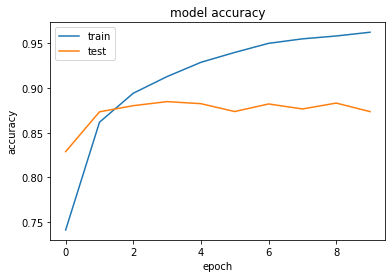

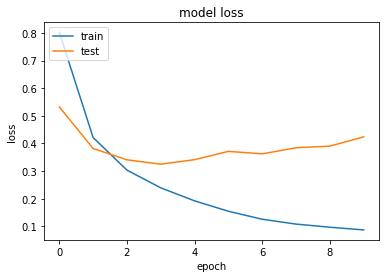

In [ ]:
history2(history)

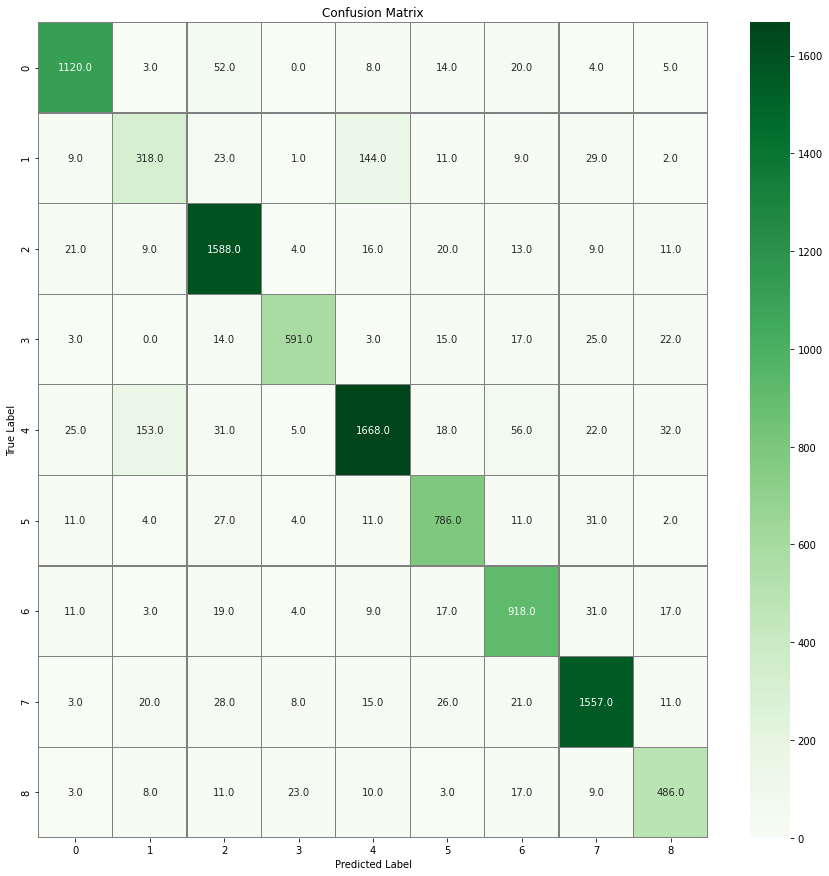

In [ ]:
confussion_mat(model)